In [8]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


In [9]:
#  Load dataset
df = pd.read_csv("../data/fraud_detection_dummy_dataset.csv")

In [10]:
# check shape and few samples
print(f'Shape: {df.shape}')
df.head()

Shape: (50000, 16)


,transaction_id,user_id,amount,payment_method,device_type,mouse_movement_score,geo_location,ip_risk_score,account_age_days,time_of_day,day_of_week,num_prev_transactions,avg_transaction_amount,is_international,is_vpn,fraud_flag
0,txn_45089,3428,40.98,credit_card,mobile,0.44,Delhi,0.22,364,20,Friday,11,108.06,0,1,0
1,txn_32802,4141,90.58,upi,tablet,0.71,Bangalore,0.12,1768,20,Wednesday,6,63.89,0,0,0
2,txn_3379,1123,26.75,bnpl,tablet,0.39,NaN,0.40,1487,9,Sunday,8,76.62,0,0,0
3,txn_10978,2930,390.88,debit_card,desktop,0.24,Unknown,NaN,1634,11,Friday,10,95.37,0,0,0
4,txn_7477,1656,51.67,credit_card,mobile,0.11,Mumbai,0.47,745,23,Thursday,8,45.94,0,0,0


In [11]:
# Check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   transaction_id          50000 non-null  object 
 1   user_id                 50000 non-null  int64  
 2   amount                  50000 non-null  float64
 3   payment_method          47488 non-null  object 
 4   device_type             47504 non-null  object 
 5   mouse_movement_score    47533 non-null  float64
 6   geo_location            45009 non-null  object 
 7   ip_risk_score           47549 non-null  float64
 8   account_age_days        50000 non-null  int64  
 9   time_of_day             50000 non-null  int64  
 10  day_of_week             47464 non-null  object 
 11  num_prev_transactions   50000 non-null  int64  
 12  avg_transaction_amount  47572 non-null  float64
 13  is_international        50000 non-null  int64  
 14  is_vpn                  50000 non-null

In [12]:
# Count of missing value per column
df.isnull().sum()

transaction_id               0
user_id                      0
amount                       0
payment_method            2512
device_type               2496
mouse_movement_score      2467
geo_location              4991
ip_risk_score             2451
account_age_days             0
time_of_day                  0
day_of_week               2536
num_prev_transactions        0
avg_transaction_amount    2428
is_international             0
is_vpn                       0
fraud_flag                   0
dtype: int64

In [13]:
# fitler only columns with nulls
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending = True)

# Display
print(f'Missing value per column : {missing}')

Missing value per column : avg_transaction_amount    2428
ip_risk_score             2451
mouse_movement_score      2467
device_type               2496
payment_method            2512
day_of_week               2536
geo_location              4991
dtype: int64


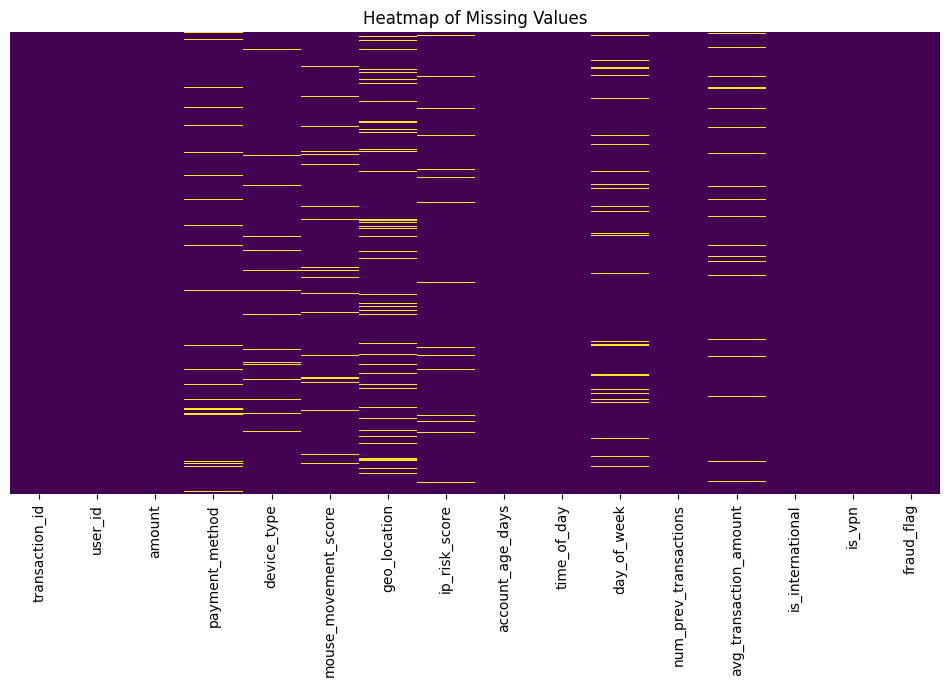

In [14]:
# Visualize missingness
plt.figure(figsize = (12,6))
sns.heatmap(df.isnull(), cbar = False, yticklabels = False, cmap = "viridis")
plt.title("Heatmap of Missing Values")
plt.show()

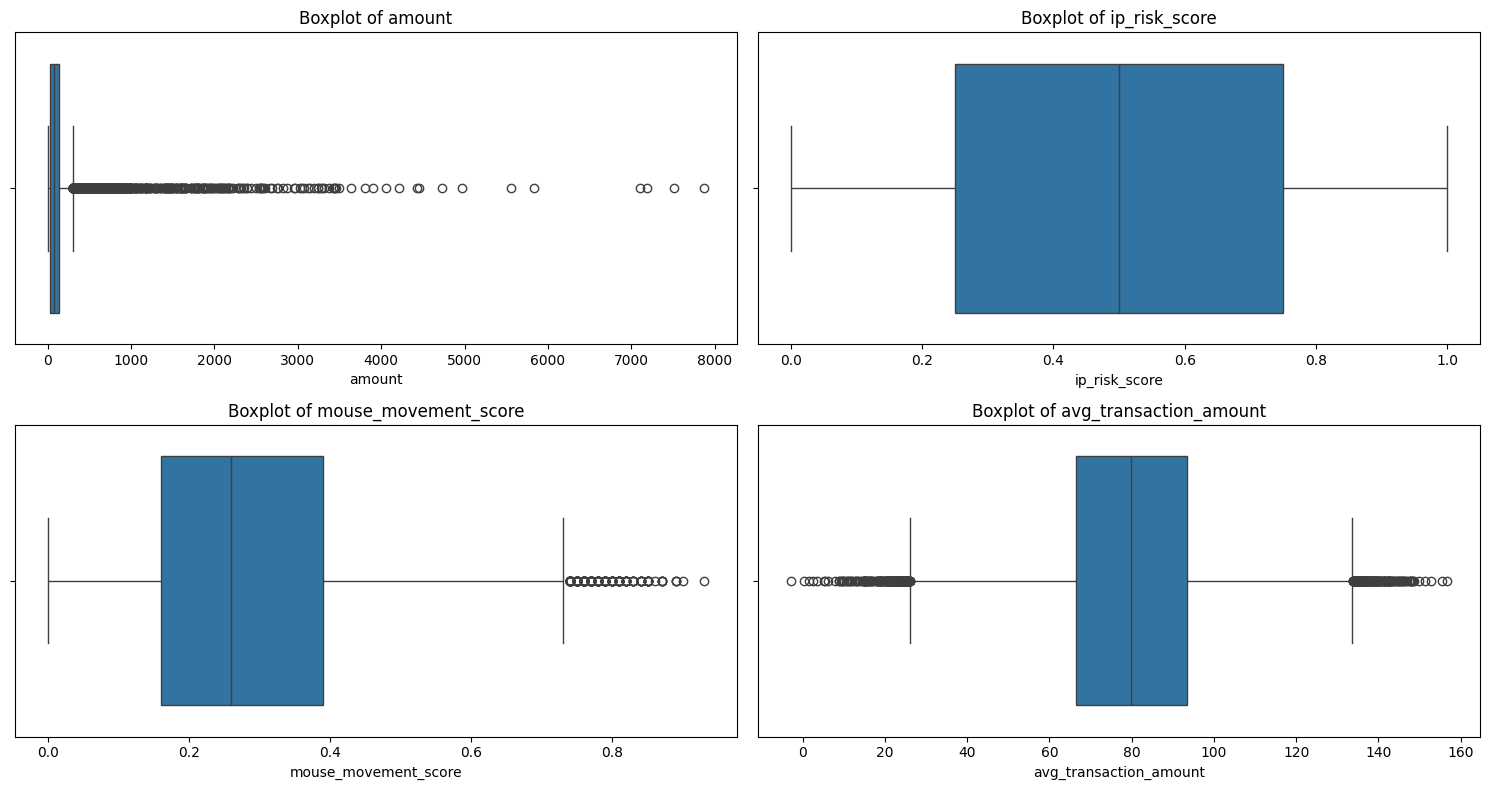

In [15]:
# plot distribution to spot outliers
numeric_cols = ["amount", "ip_risk_score", "mouse_movement_score", 'avg_transaction_amount']
plt.figure(figsize = (15, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2,2,i)
    sns.boxplot(x = df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [16]:
# using IQR metjod of amount
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3-Q1

# Outliers detection
outliers = df[(df['amount'] < (Q1 - 1.5 * IQR)) | (df['amount'] > (Q3 + 1.5 * IQR))]
print(f'Outliers in "amount" : {len(outliers)}')

Outliers in "amount" : 2528


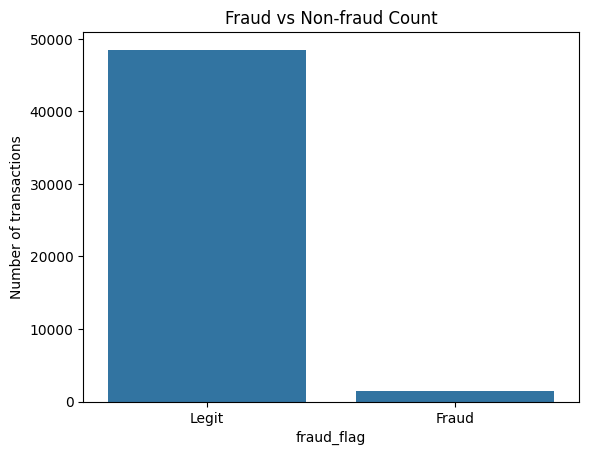

fraud_flag
0    0.97
1    0.03
Name: proportion, dtype: float64


In [17]:
# Fraud Count Plot
sns.countplot(x = 'fraud_flag', data = df)
plt.title("Fraud vs Non-fraud Count")
plt.xticks([0,1], ['Legit', 'Fraud'])
plt.ylabel("Number of transactions")
plt.show()
print(df['fraud_flag'].value_counts(normalize = True).round(3))

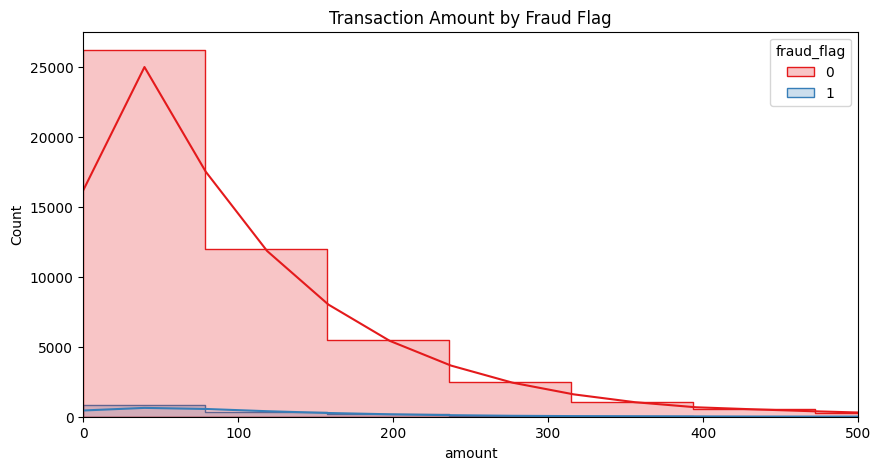

In [18]:
# Amount Distribution by Fraud
plt.figure(figsize = (10,5))
sns.histplot(data = df, x = 'amount', hue = 'fraud_flag', bins = 100, kde = True, palette = 'Set1', element = 'step')
plt.xlim(0, 500)
plt.title("Transaction Amount by Fraud Flag")
plt.show()

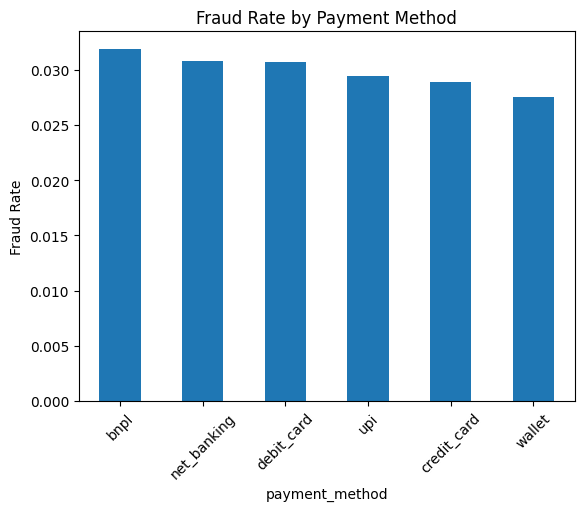

In [19]:
# Payment method vs Fraud rate
fraud_by_method = df.groupby("payment_method")["fraud_flag"].mean().sort_values(ascending = False)
fraud_by_method.plot(kind = "bar", title = "Fraud Rate by Payment Method", ylabel = "Fraud Rate")
plt.xticks(rotation = 45)
plt.show()

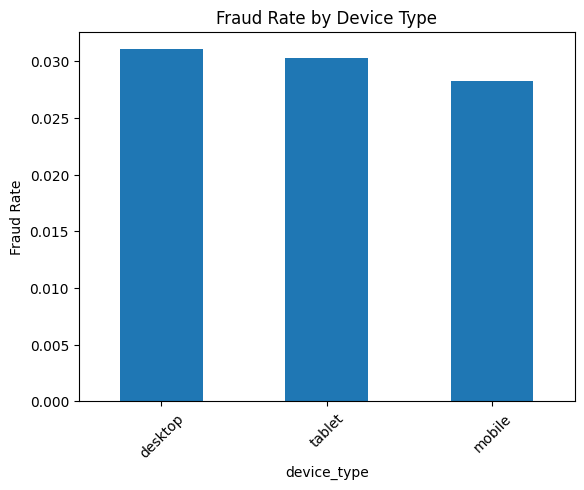

In [20]:
# Device Type vs Fraud rate
fraud_by_method = df.groupby("device_type")["fraud_flag"].mean().sort_values(ascending = False)
fraud_by_method.plot(kind = "bar", title = "Fraud Rate by Device Type", ylabel = "Fraud Rate")
plt.xticks(rotation = 45)
plt.show()

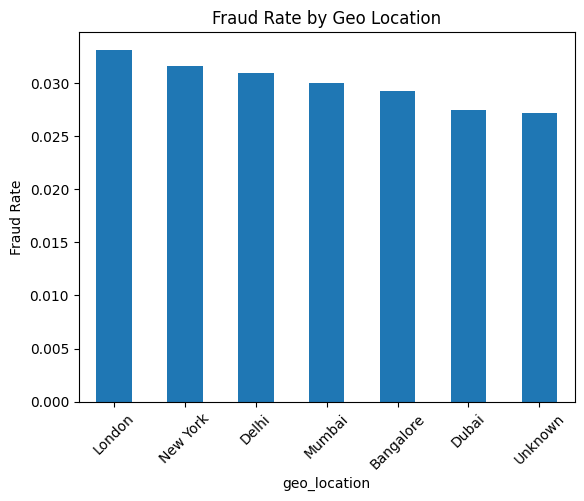

In [21]:
# Geo location vs Fraud rate
fraud_by_method = df.groupby("geo_location")["fraud_flag"].mean().sort_values(ascending = False)
fraud_by_method.plot(kind = "bar", title = "Fraud Rate by Geo Location", ylabel = "Fraud Rate")
plt.xticks(rotation = 45)
plt.show()

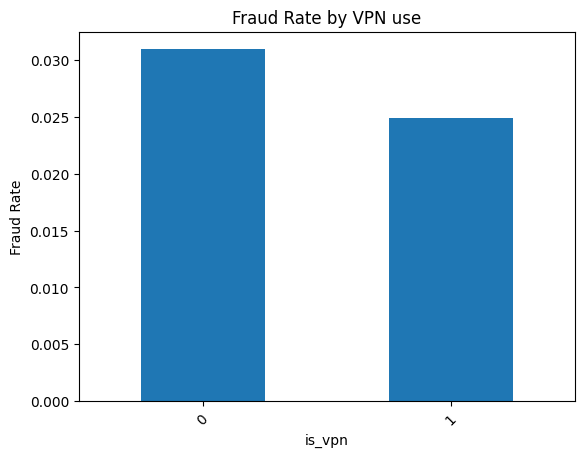

In [22]:
# VPN use vs Fraud rate
fraud_by_method = df.groupby("is_vpn")["fraud_flag"].mean().sort_values(ascending = False)
fraud_by_method.plot(kind = "bar", title = "Fraud Rate by VPN use", ylabel = "Fraud Rate")
plt.xticks(rotation = 45)
plt.show()

In [23]:
# Fill numerical Nans with median
df['mouse_movement_score'].fillna(df['mouse_movement_score'].median(), inplace = True)
df['ip_risk_score'].fillna(df['ip_risk_score'].median(), inplace = True)
df['avg_transaction_amount'].fillna(df['avg_transaction_amount'].median(), inplace = True)

# Fill Categorial Nans with mode
for col in ['payment_method','device_type', 'day_of_week', 'geo_location']:
    df[col].fillna(df[col].mode()[0], inplace = True)    

C:\Users\SAMIR\AppData\Local\Temp\ipykernel_41708\111333571.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['mouse_movement_score'].fillna(df['mouse_movement_score'].median(), inplace = True)
C:\Users\SAMIR\AppData\Local\Temp\ipykernel_41708\111333571.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [24]:

# Converting categorical to numerical values
categorical_cols = ['payment_method', 'device_type', 'geo_location', 'day_of_week']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [25]:
# Preparing train test data
X = df_encoded.drop(columns= ['transaction_id', 'fraud_flag'])
y = df_encoded['fraud_flag']

# split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (40000, 29), Test size: (10000, 29)


In [26]:
# Apply SMOTE only on the training set
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {sum(y_train==1)} fraud / {len(y_train)} total")
print(f"After SMOTE:  {sum(y_train_bal==1)} fraud / {len(y_train_bal)} total")

Before SMOTE: 1200 fraud / 40000 total
After SMOTE:  38800 fraud / 77600 total


In [27]:
# Train Random Forest Classifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_bal, y_train_bal)






# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      9700
           1       0.00      0.00      0.00       300

    accuracy                           0.97     10000
   macro avg       0.48      0.50      0.49     10000
weighted avg       0.94      0.97      0.96     10000



In [29]:
import joblib

# Save model
joblib.dump(rf_model, "../models/fraud_model_rf.joblib")

['../models/fraud_model_rf.joblib']